# Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which is the most convenient neural network environment when the work involves defining new layers. 

This homework requires sending **"multiple** files, please do not forget to include all the files when submit. The list of files:
- This notebook
- assignment1_modules.ipynb
- assignment0_differentiation.ipynb

In [5]:
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import matplotlib

%matplotlib inline

matplotlib.style.use('ggplot')

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return AND store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

In [6]:
"""
--------------------------------------
-- Tech note
--------------------------------------    
np.multiply, np.add, np.divide, np.subtract instead of *,+,/,-
for better memory handling

Suppose you allocated a variable    

    a = np.zeros(...)

So, instead of

    a = b + c  # will be reallocated, GC needed to free

I would go for: 

    np.add(b,c,out = a) # puts result in `a`

But it is completely up to you.
"""

'\n--------------------------------------\n-- Tech note\n--------------------------------------    \nnp.multiply, np.add, np.divide, np.subtract instead of *,+,/,-\nfor better memory handling\n\nSuppose you allocated a variable    \n\n    a = np.zeros(...)\n\nSo, instead of\n\n    a = b + c  # will be reallocated, GC needed to free\n\nI would go for: \n\n    np.add(b,c,out = a) # puts result in `a`\n\nBut it is completely up to you.\n'

In [7]:
# Note that every time you change assignment1_modules.ipynb, 
# you should run this cell to apply your changes
%run assignment1_modules.ipynb

Optimizer is implemented for you. 

In [8]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        Make this function faster if you can!
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0
    for cur_layer_x, cur_layer_dx in zip(x,dx):
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            cur_old_grad = config['momentum'] * cur_old_grad + config['learning_rate'] * cur_dx
            
            if cur_old_grad.shape[0] == 1:
                cur_x = cur_x.reshape(cur_old_grad.shape)
            
            state['old_grad'][i] = cur_old_grad
            
            np.add(cur_x, -cur_old_grad, out=cur_x)
            i += 1     

Implement [**Adam optimizer**](https://arxiv.org/abs/1412.6980). Test and experiment it. Write your opinion.


In [9]:
def adam_optimizer(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        Make this function faster if you can!
        
        config:
            - learning rate
            - beta0
            - beta1
            - epsilon
        state:
            - old_grad
    """
    state.setdefault('old_v', {})
    state.setdefault('old_m', {})
    state.setdefault('powBeta0', 1)
    state.setdefault('powBeta1', 1)
    
    state['powBeta0'] *= config['beta0']
    state['powBeta1'] *= config['beta1']
    
    i = 0
    for cur_layer_x, cur_layer_dx in zip(x,dx):
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_m = state['old_m'].setdefault(i, np.zeros_like(cur_dx))
            cur_old_v = state['old_v'].setdefault(i, np.zeros_like(cur_dx))
            
            cur_old_m = config['beta0']*cur_old_m + (1-config['beta0'])*cur_dx
            cur_old_v = config['beta1']*cur_old_v + (1-config['beta1'])*cur_dx**2
            
            state['old_m'][i] = cur_old_m
            state['old_v'][i] = cur_old_v
            
            m_ = cur_old_m/(1-state['powBeta0'])
            v_ = cur_old_v/(1-state['powBeta1'])
            
            np.add(cur_x, -config['learning_rate']*m_/(np.sqrt(v_)+config['epsilon']), out=cur_x)
            i += 1

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

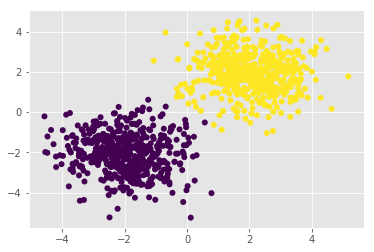

In [170]:
# Generate some data# Gener 
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [171]:
%run assignment1_modules.ipynb

criterion = CrossEntropyCriterion()

# Test something like that then 

net = Sequential()
net.add(Linear(2, 2))
net.add(Sigmoid())

print(net)

Linear 2 -> 2
Sigmoid




Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [172]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-3, 'beta0': 0.9, 'beta1': 0.999, 'epsilon': 1e-8, 'momentum': 0.9}
# optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 50
batch_size = 50

In [173]:
# batch generator
def get_batches(X, Y, batch_size):
    n_samples = X.shape[0]
    
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

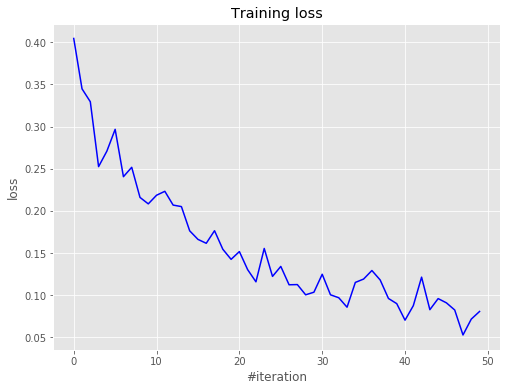

Current loss: 0.080691


In [174]:
# Note that every time you change assignment1_modules.ipynb, 
# you should run this cell to apply your changes
%run assignment1_modules.ipynb

loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches(X, Y, batch_size):
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        adam_optimizer(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)     
        
    optimizer_config['learning_rate'] /= 1.02

    # Visualize
    loss_history.append(loss)
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    
#     if loss < 0.001:
#         break

In [175]:
net.evaluate()

In [176]:
t = net.forward(X)

In [177]:
t = np.argmax(t, axis=1)
Y0 = np.argmax(Y, axis=1)
(t==Y0).sum()/1000

0.998

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [123]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
y = ohe.fit_transform(y.reshape(-1,1))

In [124]:
a = np.random.permutation(70000)

In [125]:
X = X[a]
y = y[a]

In [126]:
trainX = X[:50000]
trainY = y[:50000]

valX = X[50000:-10000]
valY = np.argmax(y[50000:-10000], axis=1)

testX = X[-10000:]
testY = y[-10000:]


In [127]:
print(valY)

[7 6 0 ... 9 7 2]


In [24]:
%run assignment1_modules.ipynb

criterion = CrossEntropyCriterion()

# Test something like that then 

net = Sequential()
net.add(Linear(784, 1000))
# net.add(BatchMeanSubtraction())
net.add(ReLU())
net.add(Linear(1000, 500))
# net.add(BatchMeanSubtraction())
net.add(Dropout())
net.add(Linear(500, 150))
# net.add(BatchMeanSubtraction())
net.add(ReLU())
net.add(Linear(150,10))
net.add(SoftMax())

print(net)

Linear 784 -> 1000
ReLU
Linear 1000 -> 500
Dropout
Linear 500 -> 150
ReLU
Linear 150 -> 10
SoftMax



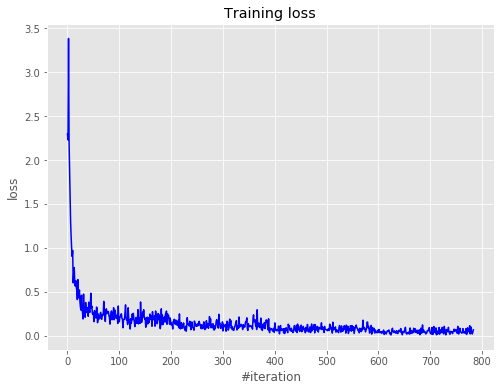

Current loss: 0.068388
Epoch_number: 3
97.31


In [25]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-2, 'beta0': 0.9, 'beta1': 0.999, 'epsilon': 1e-8, 'momentum': 0.9}
# optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 100
batch_size = 256

loss_history = []

for i in range(n_epoch):
    t = 0
    for x_batch, y_batch in get_batches(trainX, trainY, batch_size):
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        adam_optimizer(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)
        t += 1
        if t%1 == 0:
            loss_history.append(loss)


    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    optimizer_config['learning_rate'] /= 1.5
    print('Current loss: %f' % loss)
    print('Epoch_number: %d' % i)
    
    net.evaluate()
    acc = np.sum(np.argmax(net.forward(valX), axis=1)==valY)/100
    net.training()
    print(acc)
    if acc > 97.:
        break

In [26]:
net.evaluate()
z = net.forward(testX)
z[0]

array([4.27131228e-36, 1.03260990e-28, 2.17972492e-37, 5.01407836e-13,
       9.56555922e-38, 1.00000000e+00, 2.22122731e-35, 2.68406901e-37,
       2.70824414e-29, 4.71309161e-22])

In [27]:
z = np.argmax(z, axis=1)

In [28]:
zz = np.argmax(testY, axis=1)

In [29]:
(zz == z).sum()/z.shape[0]

0.9723

Write your personal opinion on the activation functions, think about computation times too. Does `BatchMeanSubtraction` help?

**Finally**, use all your knowledge to build a super cool model on this dataset, do not forget to split dataset into train and validation. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. 

Print here your accuracy. It should be around 90%.

In [30]:
(zz == z).sum()/z.shape[0]*100

97.23

# Autoencoder (optional) 

This part is **OPTIONAL**, you may not do it. It will not be scored, but it is easy and interesting.

Now we are going to build a cool model, named autoencoder. The aim is simple: **encode** the data to a lower dimentional representation. Why? Well, if we can **decode** this representation back to original data with "small" reconstuction loss then we can store only compressed representation saving memory. But the most important thing is -- we can reuse trained autoencoder for classification. 
![](img/autoencoder.png)

Picture from this [site](http://multithreaded.stitchfix.com/blog/2015/09/17/deep-style/).

Now implement an autoencoder:

Build it such that dimetionality inside autoencoder changes like that: 

$$784 \text{ (data)} -> 512 -> 256 -> 128 -> 30 -> 128 -> 256 -> 512 -> 784$$

Use **MSECriterion** to score the reconstruction. Use **BatchMeanNormalization** between **Linear** and **ReLU**. You may not use nonlinearity in bottleneck layer.

You may train it for 9 epochs with batch size = 256, initial lr = 0.1 droping by a factor of 2 every 3 epochs. The reconstruction loss should be about 6.0 and visual quality decent already.
Do not spend time on changing architecture, they are more or less the same. 

In [141]:
# %run assignment1_modules.ipynb
crit = MSECriterion()

netAE = Sequential()

# netAE.add(Linear(784, 784))

# netAE.add(Linear(784, 784))

l1 = Linear(784, 512)
b1 = BatchMeanSubtraction()
a1 = ReLU()

l2 = Linear(512, 256)
b2 = BatchMeanSubtraction()
a2 = ReLU()

l3 = Linear(256, 128)
b3 = BatchMeanSubtraction()
a3 = ReLU()

l4 = Linear(128, 30)
b4 = BatchMeanSubtraction()
a4 = ReLU()

netAE.add(l1)
netAE.add(b1)
netAE.add(a1)

netAE.add(l2)
netAE.add(b2)
netAE.add(a2)

netAE.add(l3)
netAE.add(b3)
netAE.add(a3)

netAE.add(l4)
netAE.add(b4)
netAE.add(a4)

netAE.add(Linear(30, 128))
netAE.add(BatchMeanSubtraction())
netAE.add(ReLU())
netAE.add(Linear(128, 256))
netAE.add(BatchMeanSubtraction())
netAE.add(ReLU())
netAE.add(Linear(256, 512))
netAE.add(BatchMeanSubtraction())
netAE.add(ReLU())
netAE.add(Linear(512, 784))
netAE.add(Sigmoid())

In [142]:
def get_X_batches(X, batch_size):
    n_samples = X.shape[0]
    
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx]

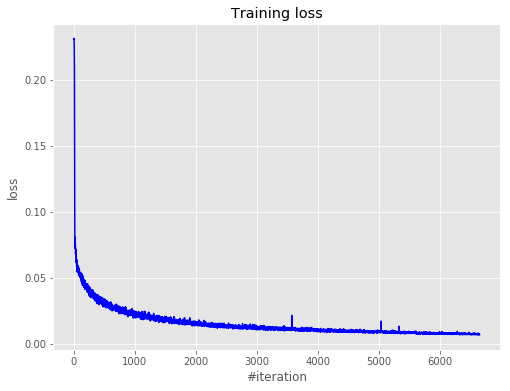

Current loss: 0.007034
Epoch_number: 18
learning_rate: 0.000751
batch_size: 400


In [143]:
optimizer_config = {'learning_rate' : 1e-3, 'beta0': 0.9, 'beta1': 0.999, 'epsilon': 1e-8, 'momentum': 0.9}
optimizer_state = {}

loss_history = []
batch_size = 128
netAE.training()
for i in range(50):
    for x_batch in get_X_batches(X, batch_size):
#         print(x_batch.shape)
        netAE.zeroGradParameters()
        
        # Forward
        predictions = netAE.forward(x_batch)
        loss = crit.forward(predictions, x_batch)
    
        # Backward
        dp = crit.backward(predictions, x_batch)
        netAE.backward(x_batch, dp)
        
        # Update weights
        adam_optimizer(netAE.getParameters(), 
                     netAE.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)
        loss_history.append(loss)
        
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)
    print('Epoch_number: %d' % (i+1))
    print('learning_rate: %f' % optimizer_config['learning_rate'])
    print('batch_size: %d' %batch_size)
    batch_size += i*2
    
    if i%5 == 2:
        optimizer_config['learning_rate'] /= 1.1
    if loss < 8e-3:
        break
        

In [146]:
netAE.evaluate()
t = netAE.forward(X)

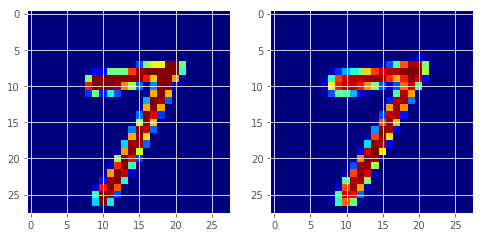

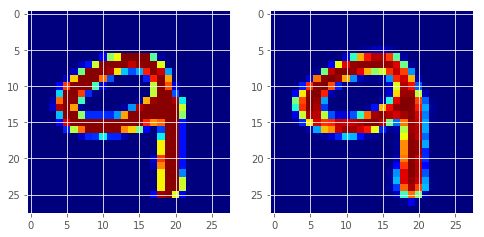

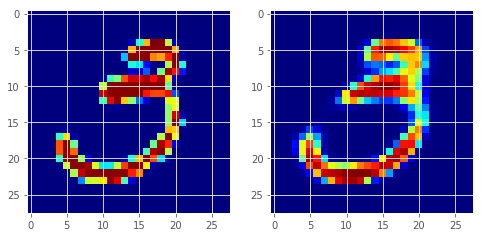

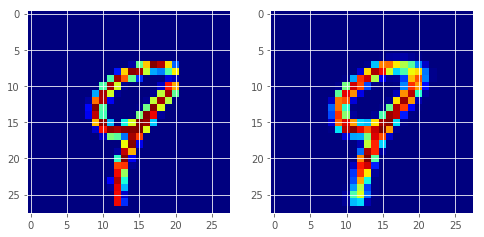

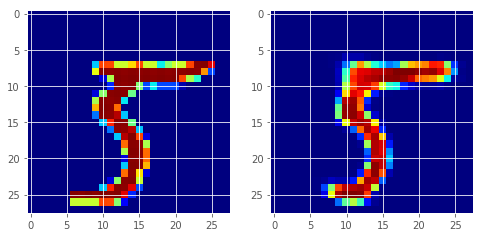

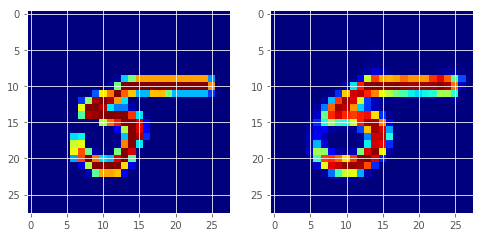

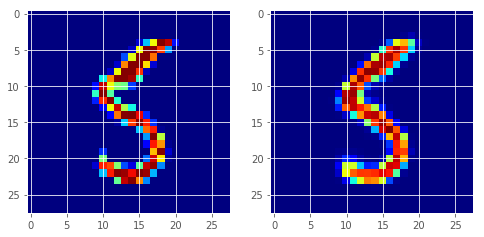

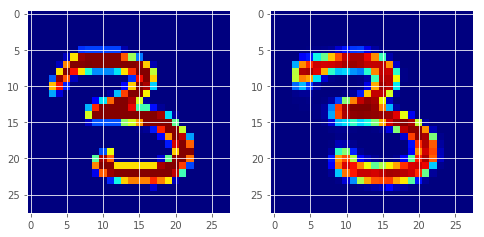

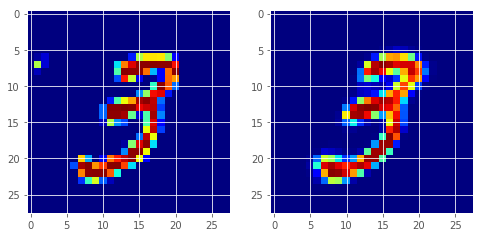

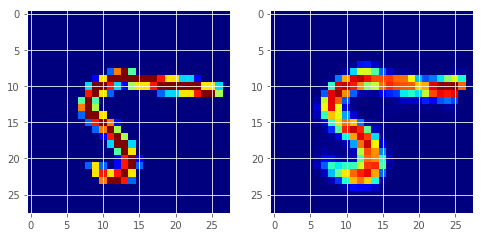

In [147]:
for i in range(10):
    u = np.random.randint(1, 60000, 1)
    fig=plt.figure(figsize=(8, 8))
    fig.add_subplot(1, 2, 1)
    plt.imshow(X[u].reshape(28, 28), cmap='jet')
    fig.add_subplot(1, 2, 2)
    plt.imshow(t[u].reshape(28, 28), cmap='jet')
plt.show()

##### Some time ago NNs were a lot poorer and people were struggling to learn deep models. To train a classification net people were training autoencoder first (to train autoencoder people were pretraining single layers with [RBM](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)), then substituting the decoder part with classification layer (yeah, they were struggling with training autoencoders a lot, and complex techniques were used at that dark times). We are going to this now, fast and easy.  

In [136]:
# Extract inner representation for train and validation, 
# you should get (n_samples, 30) matrices
# Your code goes here. ################################################

# Now build a logistic regression or small classification net

# Learn the weights
# Your code goes here. ################################################

# Now chop off decoder part
# (you may need to implement `remove` method for Sequential container) 
# Your code goes here. ################################################

# And add learned layers ontop.

# Now optimize whole model
# Your code goes here. ################################################

In [148]:
encoder = Sequential()

encoder.add(l1)
encoder.add(b1)
encoder.add(a1)

encoder.add(l2)
encoder.add(b2)
encoder.add(a2)

encoder.add(l3)
encoder.add(b3)
encoder.add(a3)

encoder.add(l4)

encoder.evaluate()

In [149]:
newX = encoder.forward(X)
trainX = newX[:50000]
valX   = newX[50000:-10000]
testX  = newX[-10000:]
newX[0]

array([ -6.68892153,  -5.77930909,  -0.7937728 ,   2.3041637 ,
         0.67753926,   4.48460862,   0.36519242,   6.68388966,
        -4.8789289 ,  -0.63482154,  -1.30830542, -13.55606278,
       -10.84184953,  -6.0849858 ,  -1.30274875,  -4.46426172,
        -8.79693889,  -1.43474875,   2.45509003, -12.3180677 ,
        -6.72392683, -12.71238519,  -6.77317528,  -2.06590145,
        -3.68749729,   5.50731822,  -6.16952789,  -3.19787775,
        -4.3638441 ,  -1.98659868])

In [164]:
%run assignment1_modules.ipynb
criterion = CrossEntropyCriterion()

netPred = Sequential()

netPred.add(Linear(30, 128))
netPred.add(BatchMeanSubtraction())
netPred.add(ReLU())
netPred.add(Linear(128, 256))
netPred.add(BatchMeanSubtraction())
netPred.add(ReLU())
netPred.add(Linear(256, 128))
netPred.add(BatchMeanSubtraction())
netPred.add(ReLU())
netPred.add(Linear(128, 64))
netPred.add(BatchMeanSubtraction())
netPred.add(ReLU())
netPred.add(Linear(64, 10))
netPred.add(SoftMax())

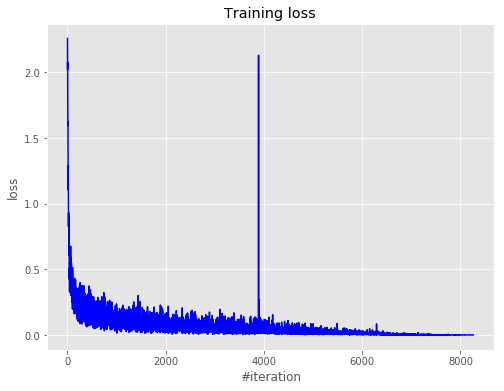

Current loss: 0.000352
Epoch_number: 50
learning_rate: 0.000453
batch_size: 1304
98.29


In [165]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-3, 'beta0': 0.9, 'beta1': 0.999, 'epsilon': 1e-8, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 50
batch_size = 128

loss_history = []

for i in range(n_epoch):
    t = 0
    for x_batch, y_batch in get_batches(trainX, trainY, batch_size):
        netPred.zeroGradParameters()
        
        # Forward
        predictions = netPred.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        netPred.backward(x_batch, dp)
        
        # Update weights
        adam_optimizer(netPred.getParameters(), 
                     netPred.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)
        loss_history.append(loss)


    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)
    print('Epoch_number: %d' % (i+1))
    print('learning_rate: %f' % optimizer_config['learning_rate'])
    print('batch_size: %d' % batch_size)
    if (i+1)%5:
        optimizer_config['learning_rate'] /= 1.02
    
    batch_size += i
    
    netPred.evaluate()
    acc = np.sum(np.argmax(netPred.forward(valX), axis=1)==valY)/100
    netPred.training()
    print(acc)
    if acc > 98.5:
        break

In [166]:
netPred.evaluate()
pred = netPred.forward(testX).argmax(axis=1)

In [167]:
(pred == testY.argmax(axis=1)).mean()*100

98.44000000000001

* What do you think, does it make sense to build real-world classifiers this way ? Did it work better for you than a straightforward one? Looks like it was not the same ~8 years ago, what has changed beside computational power? 

Run PCA with 30 components on the *train set*, plot original image, autoencoder and PCA reconstructions side by side for 10 samples from *validation set*.
Probably you need to use the following snippet to make aoutpencoder examples look comparible.

In [168]:
# np.clip(prediction,0,1)
#
# Your code goes here. ################################################

# Experiments (interesting) 

* Use ANN with one hidden layer for simple 1d regression problem (generate random points and fit your model on it).
Compare **Tanh** and **ReLu** activations for hidden layer (note that you do not need any nonlinearity for output layer). Also tweak hidden layer size.

In [178]:
X1 = np.random.normal(0, 1, 1000)
X2 = np.random.normal(2, 1.5, 1000)
X = np.hstack((X1, X2))
y = np.append(np.full((1000, 2), [0,1]), np.full((1000, 2), [1,0]), axis=0)
X = X.reshape(list(X.shape)+[1])

In [179]:
criterion = CrossEntropyCriterion()

annR = Sequential()
annR.add(Linear(1, 5))
annR.add(ReLU())
annR.add(Linear(5, 2))
annR.add(SoftMax())

annT = Sequential()
annT.add(Linear(1, 5))
annT.add(Tanh())
annT.add(Linear(5, 2))
annT.add(SoftMax())

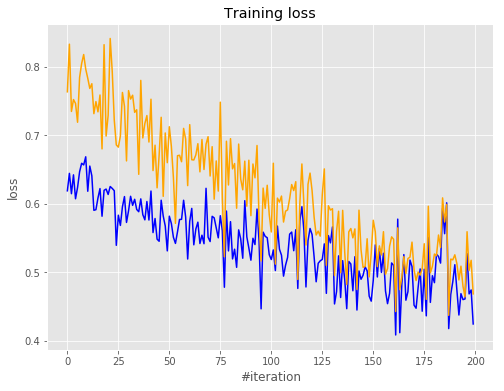

In [180]:
optimizer_config = {'learning_rate' : 1e-4, 'beta0': 0.9, 'beta1': 0.999, 'epsilon': 1e-8, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 200
batch_size = 128

loss_history_r = []
loss_history_t = []

for i in range(n_epoch):
    t = 0
    for x_batch, y_batch in get_batches(X, y, batch_size):
        annR.zeroGradParameters()
        annT.zeroGradParameters()
        
        # Forward
        predictions_r = annR.forward(x_batch)
        loss_r = criterion.forward(predictions_r, y_batch)
        
        predictions_t = annT.forward(x_batch)
        loss_t = criterion.forward(predictions_t, y_batch)
    
        # Backward
        dp_r = criterion.backward(predictions_r, y_batch)
        annR.backward(x_batch, dp_r)
        
        dp_t = criterion.backward(predictions_t, y_batch)
        annT.backward(x_batch, dp_t)
        
        # Update weights
        adam_optimizer(annR.getParameters(), 
                     annR.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)
        adam_optimizer(annT.getParameters(), 
                     annT.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)
    loss_history_r.append(loss_r)
    loss_history_t.append(loss_t)


    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history_r, 'b')
    plt.plot(loss_history_t, 'orange')
    plt.show()

* Train a multilayer model on MNIST and reach ~95% accuracy on test set. Now randomly remove neurons from your network (i.e. set neuron parameters zero). Plot test set accuracy versus number of neurons removed. Do the same expeiment with 1) Dropout layer added, 2) BatchMeanSubtraction layer added.

* Train a model on MNIST with multiclass criterion. Now backpropagate label throw network, i.e. find the input that would produce given output. Your label was one-hot-encoded (only one digit was on the picture). This time backpropagate label, which has 2 or more ones and see the input picture of the network.

In [182]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
y = ohe.fit_transform(y.reshape(-1,1))

In [184]:
X = X[a]
y = y[a]
trainX = X[:50000]
trainY = y[:50000]

valX = X[50000:-10000]
valY = np.argmax(y[50000:-10000], axis=1)

testX = X[-10000:]
testY = y[-10000:]

In [192]:
%run assignment1_modules.ipynb

criterion = MultiLabelCriterion()

# Test something like that then 

net = Sequential()
net.add(Linear(784, 500))
net.add(BatchMeanSubtraction())
net.add(ReLU())
net.add(Linear(500, 250))
net.add(BatchMeanSubtraction())
net.add(Dropout())
net.add(Linear(250, 150))
net.add(BatchMeanSubtraction())
net.add(ReLU())
net.add(Linear(150,10))
net.add(Sigmoid())

print(net)

Linear 784 -> 500
BatchMeanNormalization
ReLU
Linear 500 -> 250
BatchMeanNormalization
Dropout
Linear 250 -> 150
BatchMeanNormalization
ReLU
Linear 150 -> 10
Sigmoid



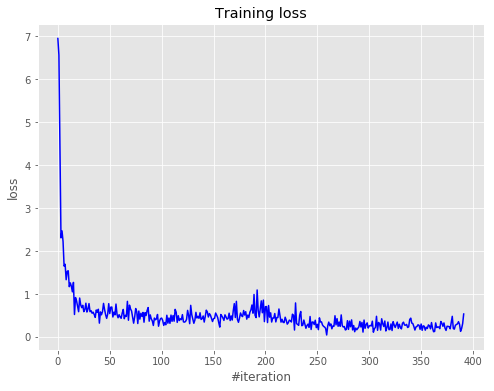

Current loss: 0.533934
Epoch_number: 1
96.22


In [193]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-2, 'beta0': 0.9, 'beta1': 0.999, 'epsilon': 1e-8, 'momentum': 0.9}
# optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 100
batch_size = 256

loss_history = []

for i in range(n_epoch):
    t = 0
    for x_batch, y_batch in get_batches(trainX, trainY, batch_size):
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        adam_optimizer(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)
        t += 1
        if t%1 == 0:
            loss_history.append(loss)


    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    optimizer_config['learning_rate'] /= 1.5
    print('Current loss: %f' % loss)
    print('Epoch_number: %d' % i)
    
    net.evaluate()
    acc = np.sum(np.argmax(net.forward(valX), axis=1)==valY)/100
    net.training()
    print(acc)
    if acc > 95.:
        break

In [230]:
net.evaluate()
z = net.forward(testX)
z = np.argmax(z, axis=1)
zz = np.argmax(testY, axis=1)
(zz == z).sum()/z.shape[0]

0.9573